# Audio Modulation and Demodulation
## AM Performance in Noise

### Step 1: Build the Envelope Detectoor
Demo Infor:

Message signal: $x(t) = \sin(2\pi f_{m1} t) + \sin(2\pi f_{m2} t)$ where $f_{m1} = 50~\text{Hz}$ and $f_{m2} = 120~\text{Hz}$.

Sampling Rate: $f_s = 1\times 10^{4}~\text{Hz}$.

Duration: $0.1~\text{s}$.

In [25]:
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt

# The envelope detector implemented using the Hilbert transform
# See: https://blog.csdn.net/m0_37262671/article/details/125303404
def get_envelope(x, n=None):
    analytic_signal = hilbert(x, N=n)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

def butter_lowpass(cutoff_frequency, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff_frequency, fs, order=4):
    b, a = butter_lowpass(cutoff_frequency, fs, order=order)
    y = lfilter(b, a, data)
    return y  

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y   

# produce AWGN noise
def awgn(x, snr_dB): # SNR in dB
    snr = 10**(snr_dB/10.0)
    xpower = np.sum(x**2)/len(x)    # power of input signal
    npower = xpower / snr        # power of noise calculated by SNR
    # gaussian noise
    noise = np.random.randn(len(x)) * np.sqrt(npower)
    return noise, npower

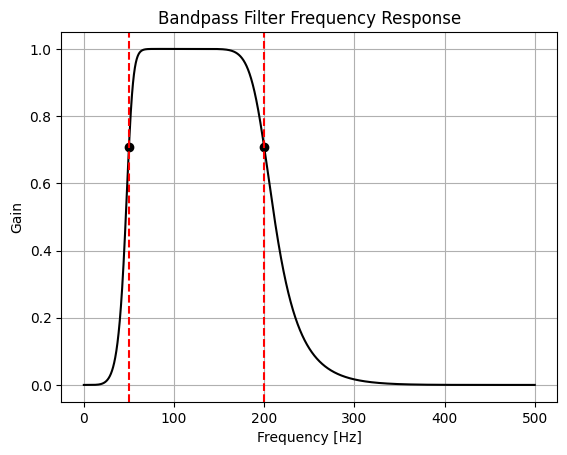

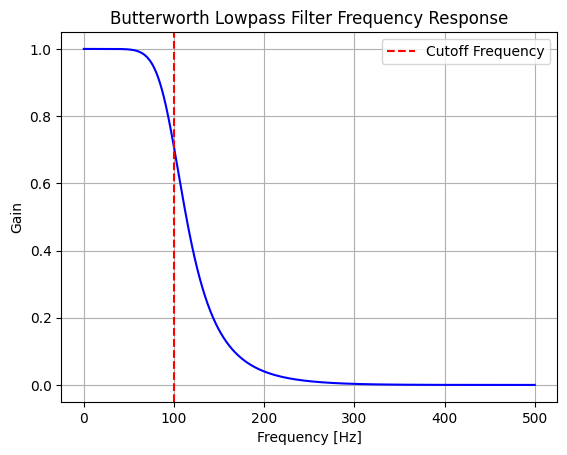

In [26]:
# !!!!!!! What is freqz???????

fs = 1000
def bpf_plot_frequency_response(lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=8000)
    plt.figure()
    plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'k')
    plt.plot(lowcut, 0.5 * np.sqrt(2), 'ko')
    plt.axvline(lowcut, color='red', linestyle='--')
    plt.plot(highcut, 0.5 * np.sqrt(2), 'ko')
    plt.axvline(highcut, color='red', linestyle='--')
    plt.title("Bandpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain')
    plt.grid()
    plt.show()

def lpf_plot_frequency_response(cutoff_frequency, fs, order=4):
    b, a = butter_lowpass(cutoff_frequency, fs, order=order)
    w, h = freqz(b, a, worN=8000)
    plt.figure()
    plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
    plt.axvline(cutoff_frequency, color='red', linestyle='--', label='Cutoff Frequency')
    plt.title("Butterworth Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain')
    plt.legend()
    plt.grid()
    plt.show()

bpf_plot_frequency_response(50, 200, 1000)
lpf_plot_frequency_response(100, 1000)

### Step 2: Generate the required AM system

In [27]:
# Generate the AM signal using specified wav file
from scipy.io import wavfile
from scipy.signal import resample

# read the wav file
fs, orig_data = wavfile.read('audio.wav')
print('Sampling rate:', fs)

# normalize the data
data = orig_data / np.max(np.abs(orig_data))

# set the carrier frequency
fc = 1e4
print('Carrier frequency: ', fc)

# generate the time vector
t = np.arange(0, len(data)/fs, 1/fs)
ka = 0.3 # the given modulation factor

# set carrier amplitude Ac
Ac = 1/(1+ka)  # carrier amplitude
bw = 2000 * 2  # bandwidth of the audio signal
print('Bandwidth of the audio signal: ', bw)

# lowpass filter the audio signal
data = butter_lowpass_filter(data, bw/2, fs, order=8)

# generate the envelope-modulated signal based on the audio signal
am_signal = Ac*(1 + ka*data) * np.cos(2*np.pi*fc*t)
am_signal_spectrum = np.fft.fft(am_signal)

# write the am_signal to a wav file
am_signal_output = am_signal / np.max(np.abs(am_signal)) * max(np.abs(orig_data))
wavfile.write('am_signal.wav', fs, am_signal_output.astype(np.int16))

Sampling rate: 48000
Carrier frequency:  10000.0
Bandwidth of the audio signal:  4000


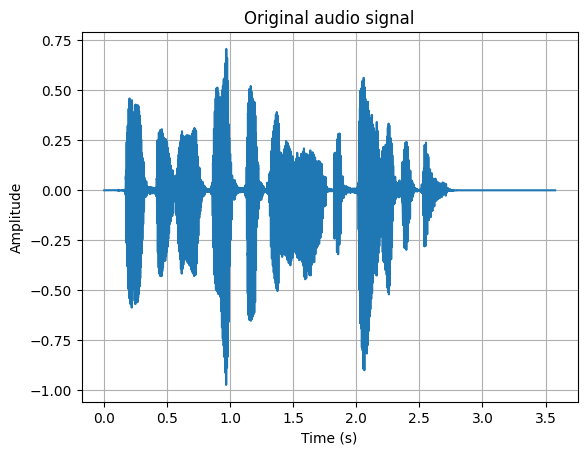

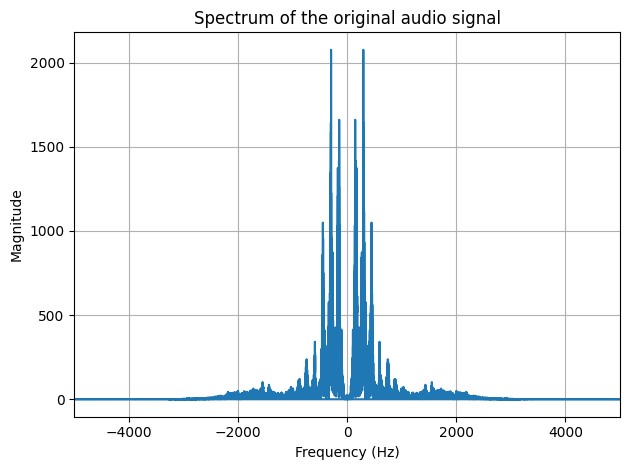

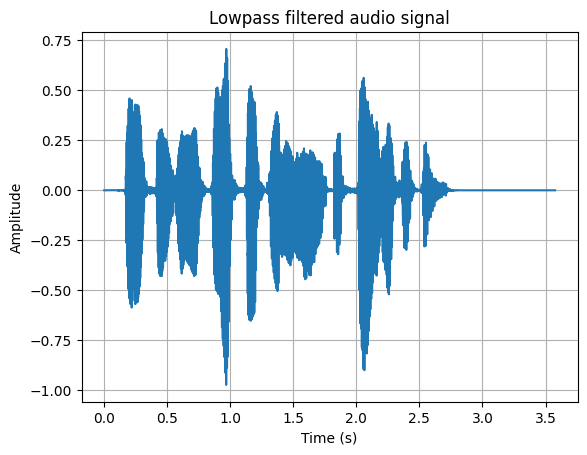

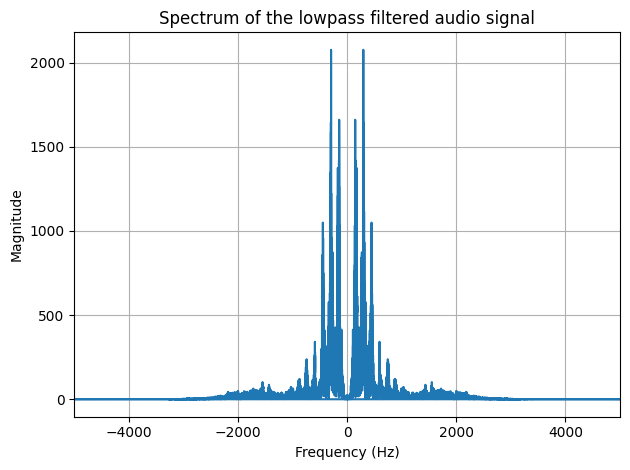

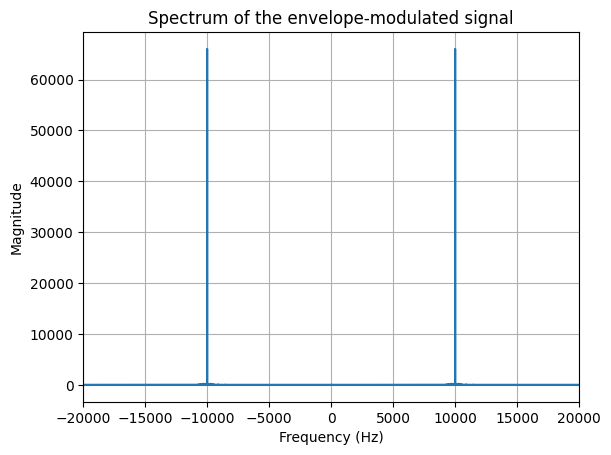

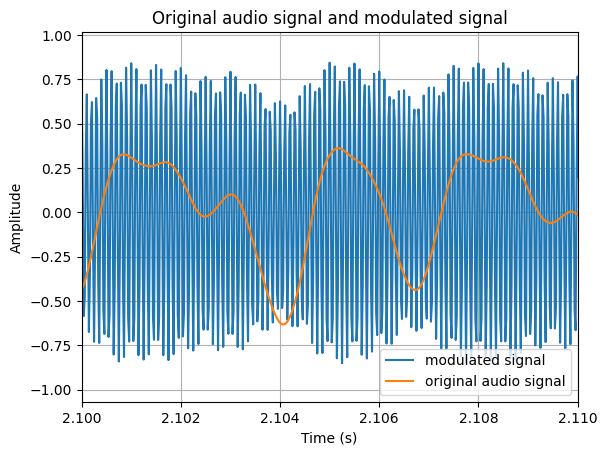

In [28]:
# Plotting
# plot the original audio signal and its spectrum using subplot
plt.figure()
plt.plot(t, data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original audio signal')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.fft.fftfreq(len(data), 1/fs), np.abs(np.fft.fft(data)))
plt.xlabel('Frequency (Hz)')
plt.xlim(-5e3, 5e3)
plt.ylabel('Magnitude')
plt.title('Spectrum of the original audio signal')
plt.grid(True)
plt.tight_layout()
plt.show()

# plot the lowpass filtered audio signal and its spectrum
plt.figure()
plt.plot(t, data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Lowpass filtered audio signal')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.fft.fftfreq(len(data), 1/fs), np.abs(np.fft.fft(data)))
plt.xlabel('Frequency (Hz)')
plt.xlim(-5e3, 5e3)
plt.ylabel('Magnitude')
plt.title('Spectrum of the lowpass filtered audio signal')
plt.grid(True)
plt.tight_layout()
plt.show()

# plot the spectrum of the envelope-modulated signal
plt.figure()
plt.plot(np.fft.fftfreq(len(am_signal), 1/fs), np.abs(am_signal_spectrum))
plt.xlabel('Frequency (Hz)')
plt.xlim(-2*fc, 2*fc)
plt.ylabel('Magnitude')
plt.title('Spectrum of the envelope-modulated signal')
plt.grid(True)
plt.show()


# plot the original audio signal and modulated signal in the same plot
# time limit 0.98s to 1s
plt.figure()
plt.plot(t, am_signal, label='modulated signal')
plt.plot(t, data, label='original audio signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([2.1, 2.11])
plt.title('Original audio signal and modulated signal')
plt.grid(True)
plt.legend()
plt.show()


### Step 3: Add some noise

In [29]:
# generate AWGN noise
snr_specified = 30 # in dB
noise, actual_noise_power = awgn(am_signal, snr_specified)

# add noise to the AM signal
noisy_am_signal = am_signal + noise

# spectrum of the noisy AM signal
noisy_am_signal_spectrum = np.fft.fft(noisy_am_signal)

# write the noisy AM signal to a wav file, avoid float endoing
wavfile.write('noisy_am_audio.wav', fs, noisy_am_signal.astype(np.int16))

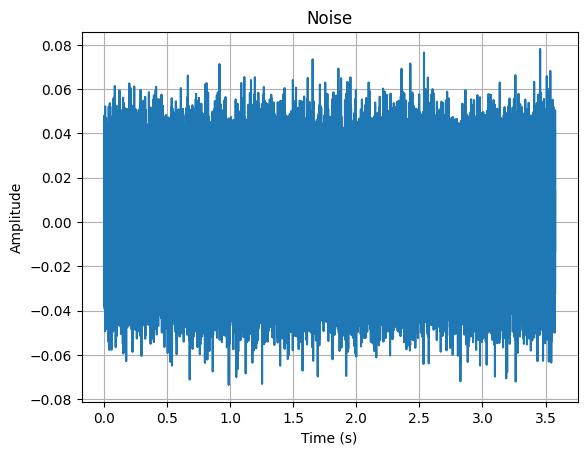

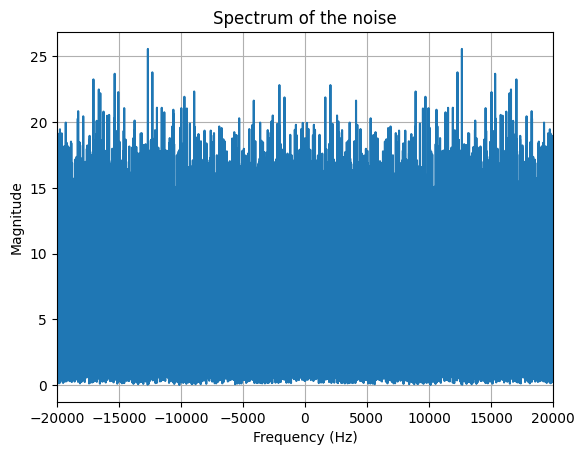

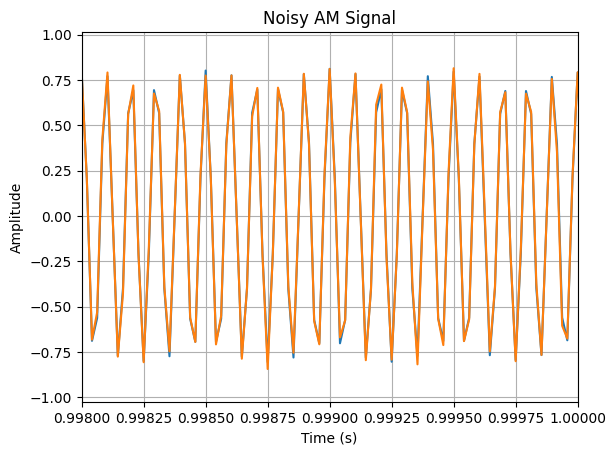

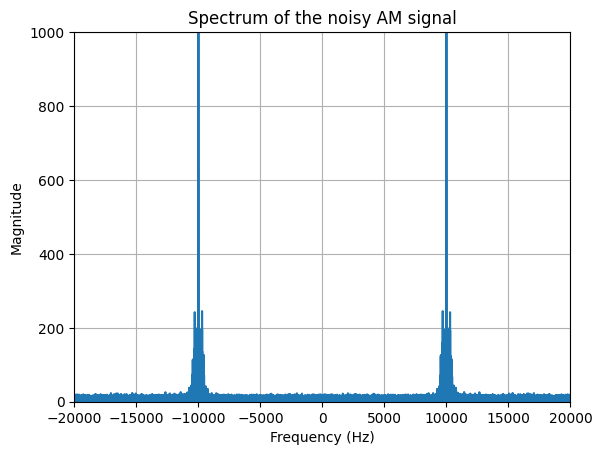

In [30]:
# plot the noise and its spectrum
plt.figure()
plt.plot(t, noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noise')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.fft.fftfreq(len(noise), 1/fs), np.abs(np.fft.fft(noise)))
plt.xlabel('Frequency (Hz)')
plt.xlim(-2*fc, 2*fc)
plt.ylabel('Magnitude')
plt.title('Spectrum of the noise')
plt.grid(True)
plt.show()

# print the noisy AM signal
plt.figure()
plt.plot(t, am_signal, label='envelope-modulated signal')
plt.plot(t, noisy_am_signal, label='noisy envelope-modulated signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0.998,1)
plt.title('Noisy AM Signal')
plt.grid(True)
plt.show()

# print the spectrum
plt.figure()
plt.plot(np.fft.fftfreq(len(noisy_am_signal), 1/fs), np.abs(noisy_am_signal_spectrum))
plt.xlabel('Frequency (Hz)')
plt.xlim(-2*fc, 2*fc)
plt.ylabel('Magnitude')
plt.ylim(0, 1000)
plt.title('Spectrum of the noisy AM signal')
plt.grid(True)
plt.show()


## Step 4: Demodulation

In [31]:
# demodulate the noisy AM signal
# multiply a local oscillator with the am signal
local_oscillator = np.cos(2*np.pi*fc*t)
multiplied_signal = noisy_am_signal * local_oscillator

# apply bpf to the demodulated signal
multiplied_signal_filtered = butter_bandpass_filter(multiplied_signal, 2*fc-bw/2, 2*fc+bw/2, fs, order=8)


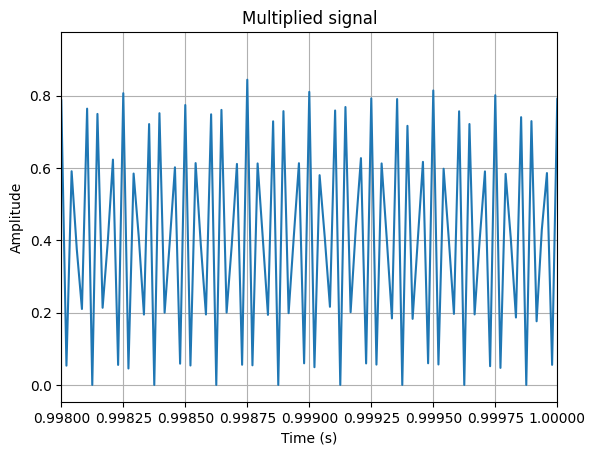

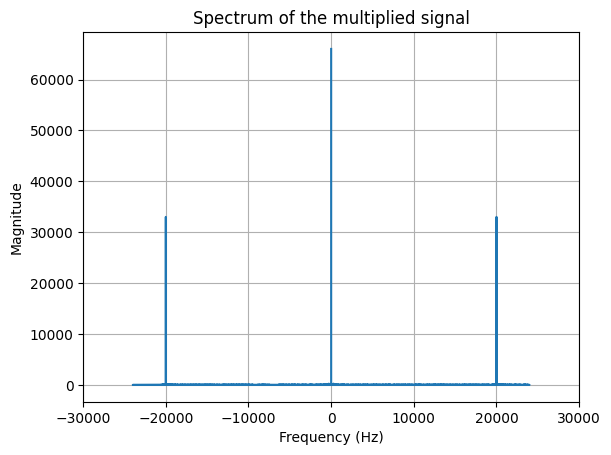

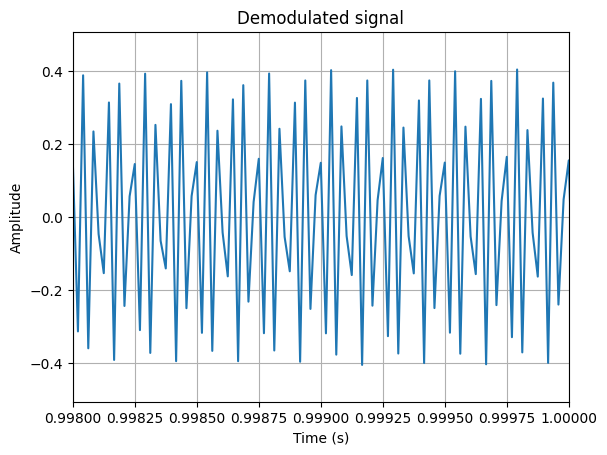

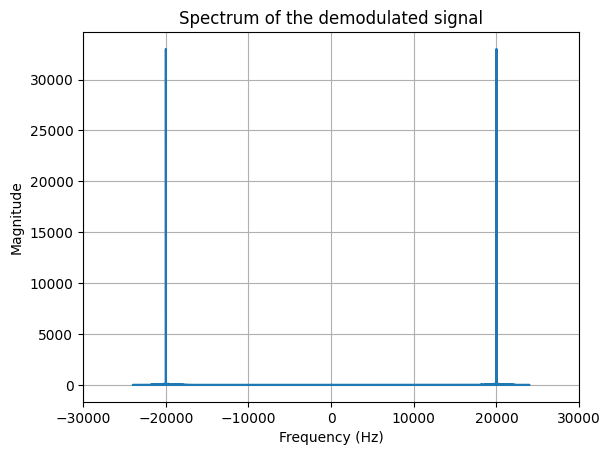

In [32]:
# plot the multiplied signal and its spectrum
plt.figure()
plt.plot(t, multiplied_signal)
plt.xlabel('Time (s)')
plt.xlim(0.998,1)
plt.ylabel('Amplitude')
plt.title('Multiplied signal')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.fft.fftfreq(len(multiplied_signal), 1/fs), np.abs(np.fft.fft(multiplied_signal)))
plt.xlabel('Frequency (Hz)')
plt.xlim(-3*fc, 3*fc)
plt.ylabel('Magnitude')
plt.title('Spectrum of the multiplied signal')
plt.grid(True)
plt.show()

# plot the demodulated signal and its spectrum
plt.figure()
plt.plot(t, multiplied_signal_filtered)
plt.xlabel('Time (s)')
plt.xlim(0.998,1)
plt.ylabel('Amplitude')
plt.title('Demodulated signal')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.fft.fftfreq(len(multiplied_signal_filtered), 1/fs), np.abs(np.fft.fft(multiplied_signal_filtered)))
plt.xlabel('Frequency (Hz)')
plt.xlim(-3*fc, 3*fc)
plt.ylabel('Magnitude')
plt.title('Spectrum of the demodulated signal')
plt.grid(True)
plt.show()



In [33]:
# multiplied_signal_filtered should go through the envelope detector
demodulated_envelope = get_envelope(multiplied_signal_filtered)

# add gain and cancel dc offset
demodulated_envelope_no_offset = (demodulated_envelope - np.mean(demodulated_envelope)) * 2

# match maximum of the demodulated signal with the original audio signal
demodulated_envelope_gain_matched = demodulated_envelope_no_offset / np.max(demodulated_envelope_no_offset) * max(orig_data)


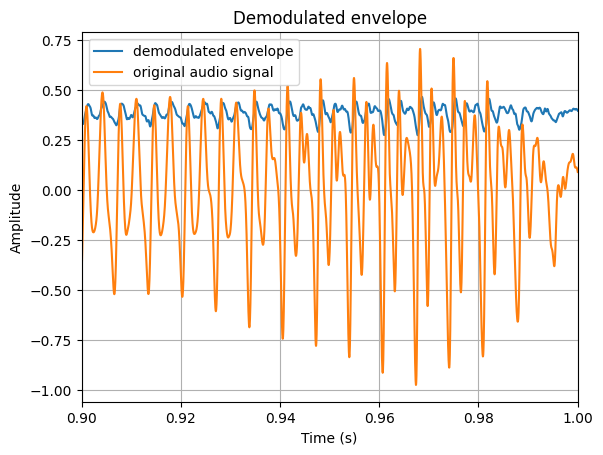

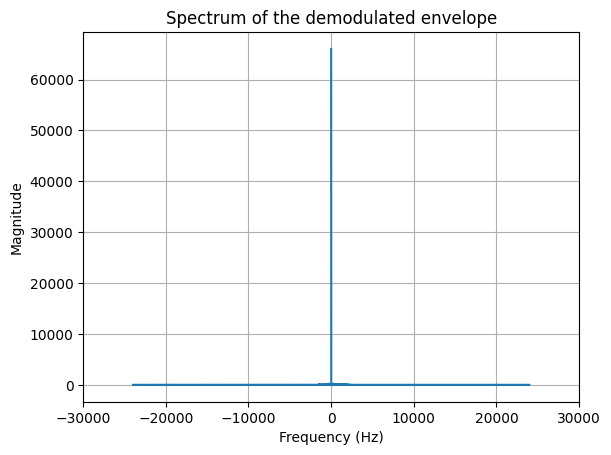

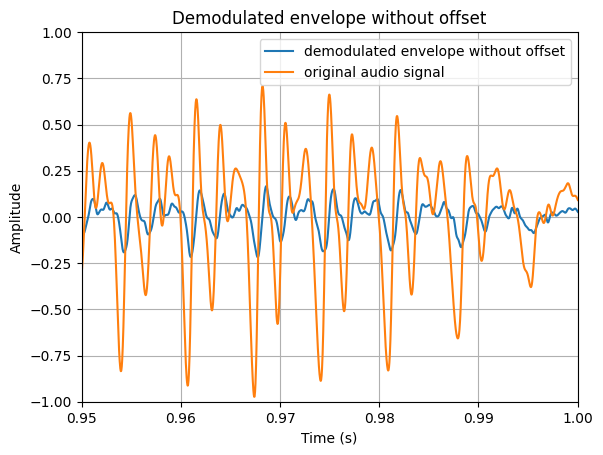

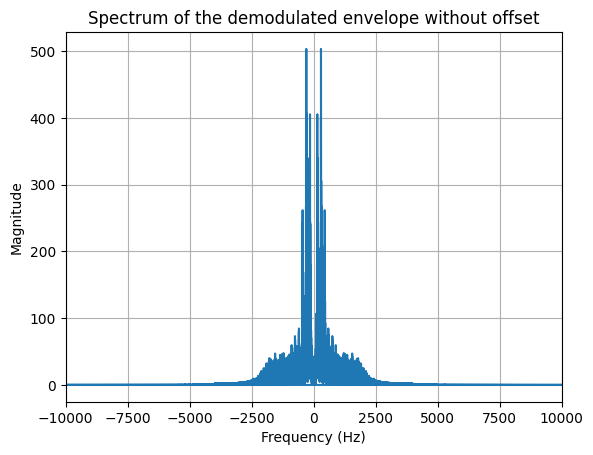

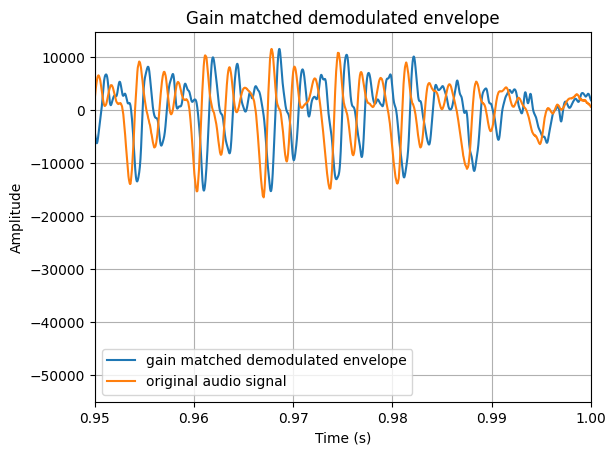

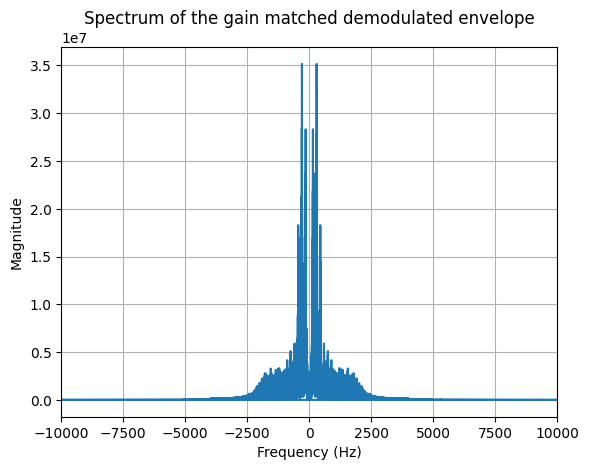

In [36]:
# plot the demodulated envelope and its spectrum
plt.figure()
plt.plot(t, demodulated_envelope)
plt.plot(t, data)
plt.xlabel('Time (s)')
plt.xlim(0.9,1)
plt.ylabel('Amplitude')
plt.title('Demodulated envelope')
plt.grid(True)
plt.legend(['demodulated envelope', 'original audio signal'])
plt.show()

plt.figure()
plt.plot(np.fft.fftfreq(len(demodulated_envelope), 1/fs), np.abs(np.fft.fft(demodulated_envelope)))
plt.xlabel('Frequency (Hz)')
plt.xlim(-3*fc, 3*fc)
plt.ylabel('Magnitude')
plt.title('Spectrum of the demodulated envelope')
plt.grid(True)
plt.show()

# plot the demodulated envelope without offset and its spectrum
plt.figure()
plt.plot(t, demodulated_envelope_no_offset)
plt.plot(t, data)
plt.xlabel('Time (s)')
plt.xlim(0.95,1)
plt.ylim(-1,1)
plt.ylabel('Amplitude')
plt.title('Demodulated envelope without offset')
plt.grid(True)
plt.legend(['demodulated envelope without offset', 'original audio signal'])
plt.show()

plt.figure()
plt.plot(np.fft.fftfreq(len(demodulated_envelope_no_offset), 1/fs), np.abs(np.fft.fft(demodulated_envelope_no_offset)))
plt.xlabel('Frequency (Hz)')
plt.xlim(-fc, fc)
plt.ylabel('Magnitude')
plt.title('Spectrum of the demodulated envelope without offset')
plt.grid(True)
plt.show()

# plot the gain matched demodulated envelope and its spectrum
plt.figure()
plt.plot(t, demodulated_envelope_gain_matched)
plt.plot(t, orig_data)
plt.xlabel('Time (s)')
plt.xlim(0.95,1)
plt.ylabel('Amplitude')
plt.title('Gain matched demodulated envelope')
plt.grid(True)
plt.legend(['gain matched demodulated envelope', 'original audio signal'])
plt.show()

plt.figure()
plt.plot(np.fft.fftfreq(len(demodulated_envelope_gain_matched), 1/fs), np.abs(np.fft.fft(demodulated_envelope_gain_matched)))
plt.xlabel('Frequency (Hz)')
plt.xlim(-fc, fc)
plt.ylabel('Magnitude')
plt.title('Spectrum of the gain matched demodulated envelope')
plt.grid(True)
plt.show()

# write the demodulated signal to a wav file
wavfile.write('demodulated_audio.wav', fs, demodulated_envelope_gain_matched.astype(np.int16))


In [35]:
# calculate pre-detection SNR
pre_detection_snr = 10*np.log10(np.sum(am_signal**2) / np.sum(noise**2))

# calculate post-detection SNR
post_detection_snr = 10*np.log10(np.sum(demodulated_envelope_gain_matched**2) /
                                    np.sum((demodulated_envelope_no_offset - data)**2))

# calculate the mean of noise in frequency domain
N0 = 2*np.mean(np.abs(np.fft.fft(noise)))
print('Mean of noise in frequency domain: ', N0)

print('Pre-detection SNR: ', pre_detection_snr)
print('Post-detection SNR: ', post_detection_snr)
print('Theoretical Pre-detection SNR: ', 10*np.log10(Ac**2 * (1 + ka**2 * np.sum(data**2))/(2 * N0 * bw)))
print('Theoretical Post-detection SNR: ', 10*np.log10(Ac**2 * ka**2 * np.sum(data**2) / (2 * N0 * bw)))



Mean of noise in frequency domain:  12.664758906077418
Pre-detection SNR:  29.98640490424405
Post-detection SNR:  86.28702298258959
Theoretical Pre-detection SNR:  -27.843326225843477
Theoretical Post-detection SNR:  -27.858790027698387
